# 콘텐츠 기반 필터링 실습 - TMDB 5000 영화 데이터 세트
#### 5000개의 영화 데이터를 기반으로 콘텐츠 기반 필터링을 수행해보자

## 장르 속성을 이용한 영화 콘텐츠 기반 필터링
#### 콘텐츠 기반 필터링 추천 시스템을 영화를 선택하는데 중요한 요소인 영화 장르 속성을 기반으로 만들어보자
#### 장르 칼럼 값의 유사도를 비교한 뒤 그중 높은 평점을 가지는 영화를 추천하는 방식이다.

## 데이터 로딩 및 가공

In [1]:
import pandas as pd
import numpy as np
import warnings; warnings.filterwarnings('ignore')

movies = pd.read_csv('./tmdb-5000-movie-dataset/tmdb_5000_movies.csv')
print(movies.shape)
movies.head()

(4803, 20)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


#### 추출할 주요 칼럼은 id, title, genres, vote_average, vote_count, popularity, keyword, overview 이다.

In [8]:
movies_df = movies[['id','title', 'genres', 'vote_average', 'vote_count',
                 'popularity', 'keywords', 'overview']]

#### 해당 문자열을 객체로 변환

In [9]:
from ast import literal_eval

movies_df['genres'] = movies_df['genres'].apply(literal_eval)
movies_df['keywords'] = movies_df['keywords'].apply(literal_eval)

#### 그리고, 장르/키워드 칼럼이 내부 딕셔너리 형태로 여러개 구성되어 있어서 의미가 있는 단어만 뽑아서 나열하자.

In [10]:
movies_df['genres'] = movies_df['genres'].apply(lambda x : [ y['name'] for y in x])
movies_df['keywords'] = movies_df['keywords'].apply(lambda x : [ y['name'] for y in x])
movies_df[['genres', 'keywords']][:1]

,genres,keywords
0,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon..."


## 장르 콘텐츠 유사도 측정
#### 장르 컬럼은 여러 개의 개별 장르가 리스트로 구성되어 있는데, 여기서 어떻게 장르별 유사도를 측정할까?
#### 간단한 방법으로는 genres를 문자열로 변경한 뒤 이를 CountVectorizer로 피처 벡터화한 행렬 데이터 값을 코사인 유사도로 비교하는 것이다.
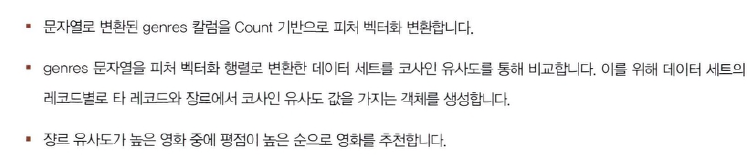

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

movies_df['genres_literal'] = movies_df['genres'].apply(lambda x : (' ').join(x))
count_vect = CountVectorizer(min_df=0, ngram_range=(1,2))
genre_mat = count_vect.fit_transform(movies_df['genres_literal'])
print(genre_mat.shape)

(4803, 276)


#### 피처 벡터 행렬이 만들어졌고, 기준 행과 비교 행의 코사인 유사도를 비교해보자
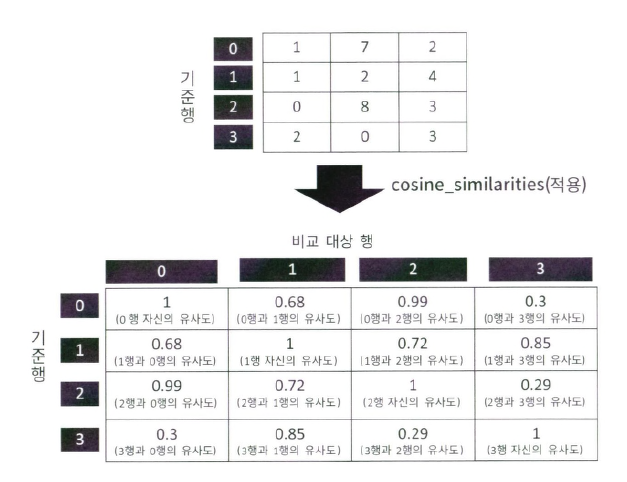

In [13]:
from sklearn.metrics.pairwise import cosine_similarity

genre_sim = cosine_similarity(genre_mat, genre_mat)
print(genre_sim.shape)
print(genre_sim[:2])

(4803, 4803)
[[1.         0.59628479 0.4472136  ... 0.         0.         0.        ]
 [0.59628479 1.         0.4        ... 0.         0.         0.        ]]


#### 개별 레코드에서 가장 장르 유사도가 높은 순으로 다른 레코드를 추출하자

In [14]:
genre_sim_sorted_ind = genre_sim.argsort()[:, ::-1]
print(genre_sim_sorted_ind[:1])

[[   0 3494  813 ... 3038 3037 2401]]


#### 0번 레코드의 경우 자기 자신을 제외하여 3494번 레코드가 가장 유사도가 높다.

## 장르 콘텐츠 필터링을 이용한 영화 추천
#### 장르 유사도에 따른 영화를 추천하는 함수를 생성하자

In [15]:
def find_sim_movie(df, sorted_ind, title_name, top_n=10):
    title_movie = df[df['title'] == title_name]
    
    title_index = title_movie.index.values
    similar_indexes = sorted_ind[title_index, :(top_n)]
    
    print(similar_indexes)
    similar_indexes = similar_indexes.reshape(-1)
    
    return df.iloc[similar_indexes]

In [16]:
similar_moives = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather', 10)
similar_moives[['title', 'vote_average']]

[[2731 1243 3636 1946 2640 4065 1847 4217  883 3866]]


,title,vote_average
2731,The Godfather: Part II,8.3
1243,Mean Streets,7.2
3636,Light Sleeper,5.7
1946,The Bad Lieutenant: Port of Call - New Orleans,6.0
2640,Things to Do in Denver When You're Dead,6.7
4065,Mi America,0.0
1847,GoodFellas,8.2
4217,Kids,6.8
883,Catch Me If You Can,7.7
3866,City of God,8.1


#### 단순 장르로 비교했을 때, 평점이 매우 낮은 후보들이 존재한다. 좀 더 개선이 필요
#### 좀 더 많은 후보군을 선정한 뒤에 영화의 평점에 따라 필터링해서 최종 추천하는 방식으로 변경하자

In [17]:
movies_df[['title', 'vote_average', 'vote_count']].sort_values('vote_average', ascending=False)[:10]

,title,vote_average,vote_count
3519,Stiff Upper Lips,10.0,1
4247,Me You and Five Bucks,10.0,2
4045,"Dancer, Texas Pop. 81",10.0,1
4662,Little Big Top,10.0,1
3992,Sardaarji,9.5,2
2386,One Man's Hero,9.3,2
2970,There Goes My Baby,8.5,2
1881,The Shawshank Redemption,8.5,8205
2796,The Prisoner of Zenda,8.4,11
3337,The Godfather,8.4,5893


#### 이 처럼 평가 횟수가 작은 왜곡된 평점 데이터를 회피할 수 있는 새로운 평가 방식이 필요하다
#### 평가 횟수에 대한 가중치가 부여된 평점 방식을 사용하자
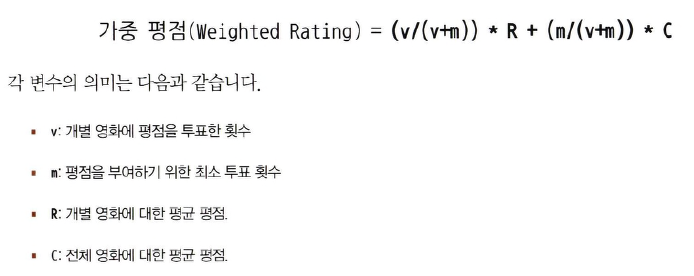

In [18]:
# 상위 60% 횟수를 최소 특표 횟수로 설정
percentile = 0.6
m = movies_df['vote_count'].quantile(percentile)
C = movies_df['vote_average'].mean()

def weighted_vote_average(record):
    v = record['vote_count']
    R = record['vote_average']
    
    return ( (v/(v+m)) * R ) + ( (m/(m+v)) * C )   

movies_df['weighted_vote'] = movies_df.apply(weighted_vote_average, axis=1) 

#### 새롭게 부여된 weighted_vote 평점이 높은 순으로 상위 10개의 영화를 추출해보자


In [19]:
movies_df[['title','vote_average','weighted_vote','vote_count']].sort_values('weighted_vote',
                                                                          ascending=False)[:10]

,title,vote_average,weighted_vote,vote_count
1881,The Shawshank Redemption,8.5,8.396052,8205
3337,The Godfather,8.4,8.263591,5893
662,Fight Club,8.3,8.216455,9413
3232,Pulp Fiction,8.3,8.207102,8428
65,The Dark Knight,8.2,8.136930,12002
1818,Schindler's List,8.3,8.126069,4329
3865,Whiplash,8.3,8.123248,4254
809,Forrest Gump,8.2,8.105954,7927
2294,Spirited Away,8.3,8.105867,3840
2731,The Godfather: Part II,8.3,8.079586,3338


#### 새롭게 정의된 평점 기준에 따라 다시 영화를 추천해보자

In [20]:
def find_sim_movie(df, sorted_ind, title_name, top_n=10):
    title_movie = df[df['title'] == title_name]
    title_index = title_movie.index.values
    
    # top_n의 2배에 해당하는 쟝르 유사성이 높은 index 추출 
    similar_indexes = sorted_ind[title_index, :(top_n*2)]
    similar_indexes = similar_indexes.reshape(-1)
# 기준 영화 index는 제외
    similar_indexes = similar_indexes[similar_indexes != title_index]
    
    # top_n의 2배에 해당하는 후보군에서 weighted_vote 높은 순으로 top_n 만큼 추출 
    return df.iloc[similar_indexes].sort_values('weighted_vote', ascending=False)[:top_n]

similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather',10)
similar_movies[['title', 'vote_average', 'weighted_vote']]

,title,vote_average,weighted_vote
2731,The Godfather: Part II,8.3,8.079586
1847,GoodFellas,8.2,7.976937
3866,City of God,8.1,7.759693
1663,Once Upon a Time in America,8.2,7.657811
883,Catch Me If You Can,7.7,7.557097
281,American Gangster,7.4,7.141396
4041,This Is England,7.4,6.739664
1149,American Hustle,6.8,6.717525
1243,Mean Streets,7.2,6.626569
2839,Rounders,6.9,6.530427
